In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
df = pd.read_csv('flight-price-prediction/flight_price_processed.csv')
df.head()

,Stops,Class,Duration,Days Left,Price,Airline_Air_India,Airline_GO_FIRST,Airline_Indigo,Airline_SpiceJet,Airline_Vistara,...,Departure Time_Early_Morning,Departure Time_Evening,Departure Time_Late_Night,Departure Time_Morning,Departure Time_Night,Arrival Time_Early_Morning,Arrival Time_Evening,Arrival Time_Late_Night,Arrival Time_Morning,Arrival Time_Night
0,0,0,-1.397994,-1.843875,5953,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,-1.374820,-1.843875,5953,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,-1.397994,-1.843875,5956,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,-1.386407,-1.843875,5955,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,-1.374820,-1.843875,5955,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [3]:
# Define features and target variable
X = df.drop('Price', axis=1)
y = df['Price']

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [6]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [7]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
print(f"R-squared: {r2_score(y_test, y_pred):.4f}")

R-squared: 0.9847


In [8]:
# Feature Importance (Replacing Coefficients)
# Random Forest doesn't have "positive/negative" coefficients, just "Importance"
importances = rf_model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

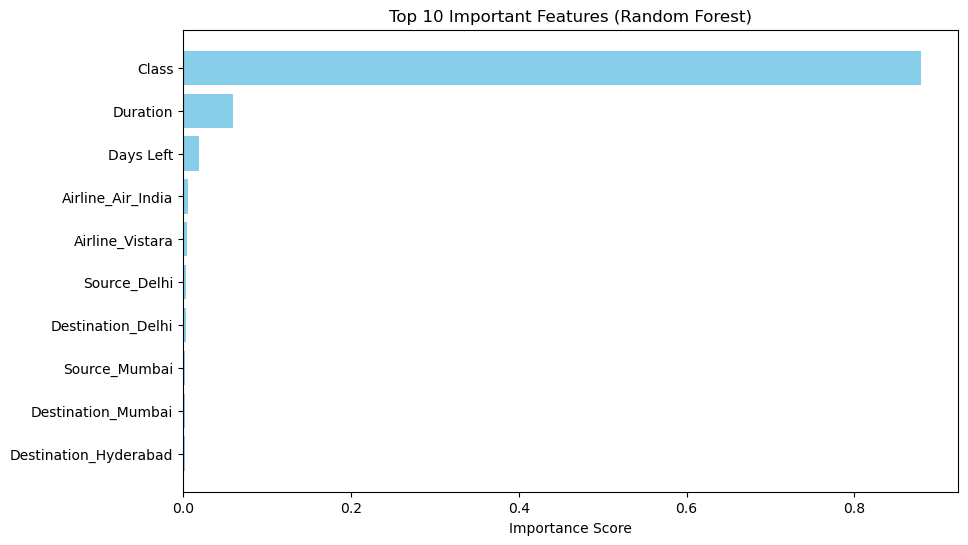

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() # Highest importance on top
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

In [10]:
# Save the plot
plt.savefig('visualizations/rf_importance_plot.png')

<Figure size 640x480 with 0 Axes>

GridSearchCV & Hyperparameter Tuning

In [11]:
# Split FULL Data (for final evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# OPTIMIZATION TRICK (Tuning on a Sample)
# We take a random sample of 50,000 rows just for finding the best settings.
# This makes the search 6x faster than using the full 300k rows.
X_train_sample = X_train.sample(n=50000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [13]:
# Define Hyperparameters to test
# RandomizedSearch is usually better than GridSearch for large datasets
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [14]:
# Run Tuning on the SAMPLE
rf_tuner = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=15,          # Try 15 random combinations
    cv=3,               # 3-fold cross-validation
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Tuning on sample data (this is fast)...")
rf_tuner.fit(X_train_sample, y_train_sample)

Tuning on sample data (this is fast)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='r2', verbose=1)

In [15]:
print(f"Best Parameters found: {rf_tuner.best_params_}")

Best Parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [16]:
# TRAIN FINAL MODEL ON FULL DATASET
# Now we use the best parameters found above, but train on the FULL X_train
print("\nTraining final model on full dataset (this takes longer, but is accurate)...")

final_model = RandomForestRegressor(
    n_estimators=300,       # Your result
    max_depth=None,         # Your result
    min_samples_split=2,    # Your result
    min_samples_leaf=1,     # Your result
    random_state=42,
    n_jobs=-1               # Use all CPU cores to speed it up
)

final_model.fit(X_train, y_train)


Training final model on full dataset (this takes longer, but is accurate)...


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [17]:
# Evaluate
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("-" * 30)
print(f"Final Test R-squared: {r2:.4f}")
print(f"Average Error (MAE): {mae:.2f}")
print("-" * 30)

------------------------------
Final Test R-squared: 0.9848
Average Error (MAE): 1085.87
------------------------------


Tuning Graph

In [18]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the values of max_depth we want to test
depth_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Lists to store the results
train_scores = []
test_scores = []

In [19]:
# Loop through each depth
print("Training models with different depths...")
for depth in depth_values:
    # Initialize model with the specific depth
    # n_estimators=20 is used here to make the code run faster for this demonstration.
    rf = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=42, n_jobs=-1)
    
    # Train
    rf.fit(X_train, y_train)
    
    # Record accuracy (R-squared)
    # rf.score() calculates R-squared by default for Regressors
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    
    print(f"Finished Depth {depth}")

Training models with different depths...
Finished Depth 1
Finished Depth 5
Finished Depth 10
Finished Depth 15
Finished Depth 20
Finished Depth 25
Finished Depth 30
Finished Depth 35
Finished Depth 40
Finished Depth 45
Finished Depth 50


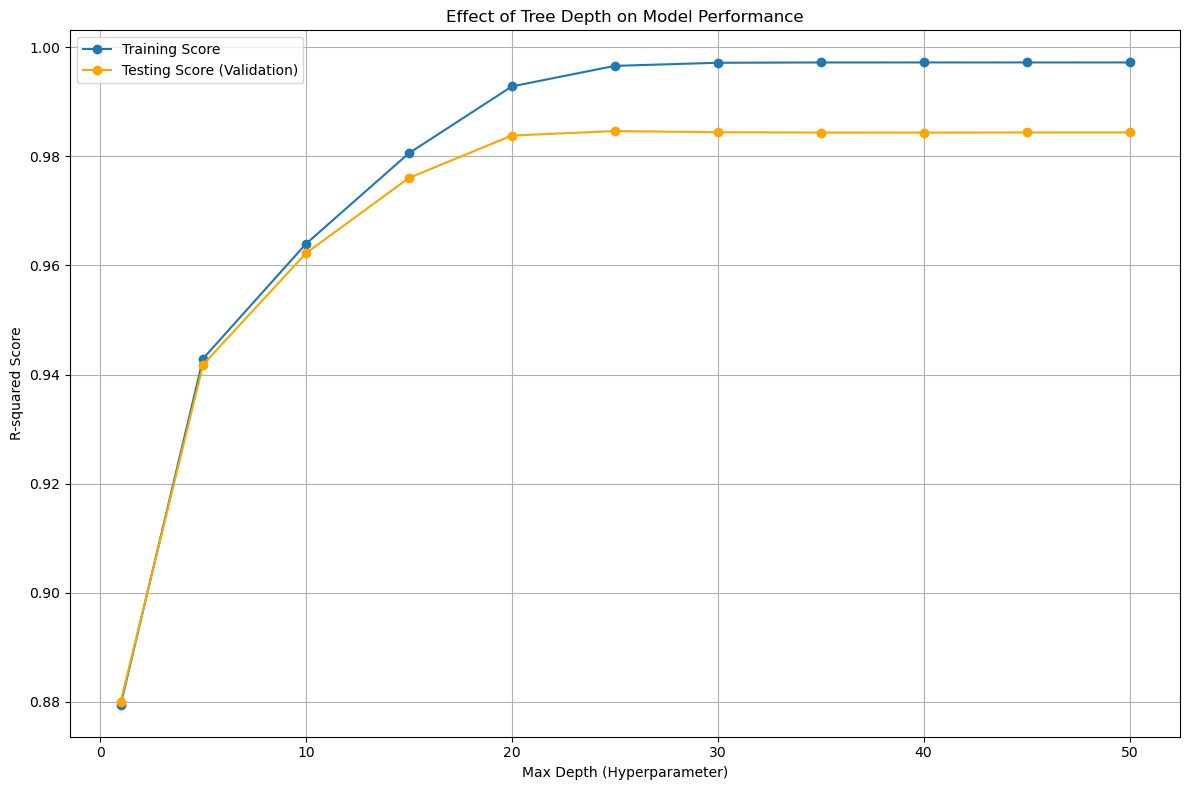

In [20]:
# Plot the results
plt.figure(figsize=(12, 8))

# Plot Training scores
plt.plot(depth_values, train_scores, label='Training Score', marker='o', linestyle='-')

# Plot Testing scores
plt.plot(depth_values, test_scores, label='Testing Score (Validation)', marker='o', linestyle='-', color='orange')

plt.title('Effect of Tree Depth on Model Performance')
plt.xlabel('Max Depth (Hyperparameter)')
plt.ylabel('R-squared Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

What to look for in the graph

- The Gap: You want to pick a depth where the orange line (Test Score) is high, but before the blue line (Train Score) gets too far away from it. A large gap indicates overfitting.

- The Plateau: Once the orange line flattens out, adding more depth doesn't help—it just wastes memory.

In [58]:
# Save/Show
plt.savefig('visualizations/rf_tuning_curve.png')
plt.show()

<Figure size 640x480 with 0 Axes>